In [2]:
%matplotlib inline
# -*- coding: utf-8 -*-
"""
Created on Wed Feb 28 09:52:05 2018

@author: yann
"""

from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy.convolution import convolve, convolve_fft

import scipy.io as sio
from scipy import signal
import progressbar


def psf2otf(psf, s):
    """
    Get OTF (Optical Transfer Function) from PSF (Point Spread Function)
    OTF is basically the Fourier Transform of the PSF, centerd
    psf: PSF 
    s: shape of the result, zero-padding is used to center is Fourier Transform
    """
    sh = psf.shape
    sh = np.array(sh)
    s = np.array(s)
    pad = s - sh
    h = np.pad(psf, ((0, pad[0]), (0, pad[1])), mode='constant')
    shift = (int(pad[0]/2+1), int(pad[1]/2+1))
    h_centered = np.roll(h, tuple(shift), axis=(0, 1))
    h_centered = np.fft.fftshift(h_centered)
    H = np.fft.fft2(h_centered, s)
    H = np.real(H)
    return H


def checkerboard(s=8):
    return np.kron([[1, 0] * 4, [0, 1] * 4] * 4, np.ones((s, s)))

def addGaussianNoise(I, sigma=1000):
    """Adds Gaussian noise to an image
    I: original image
    sigma: signal/noise ratio
    """
    I2 = I.copy()
    m = np.min(I)
    M = np.max(I)
    N = (M-m)/sigma*np.random.randn(I.shape[0], I.shape[1])
    I2 = I2 + N
    I2[I2 > M] = M
    I2[I2 < m] = m
    return I2, I-I2

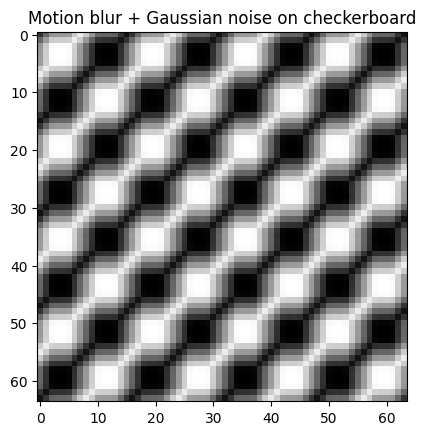

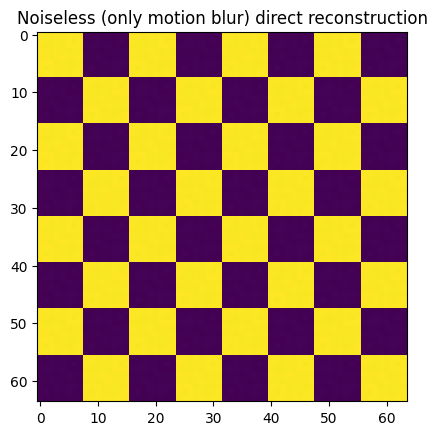

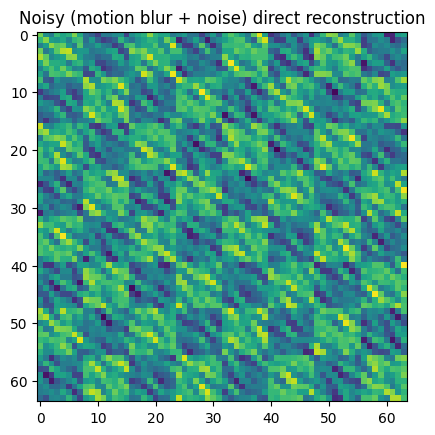

In [3]:
###############################################################################
""" Test simple deconvolution in Fourier space
"""
C = checkerboard()
psf = np.load('psf_motion.npy')
Cb = signal.convolve2d(C, psf, boundary='wrap', mode='same')

Cbn, noise = addGaussianNoise(Cb)
plt.imshow(Cbn, cmap='gray')
plt.title('Motion blur + Gaussian noise on checkerboard')
plt.show()
plt.imsave("test/cbn_original.png", Cbn, cmap='gray')

# test reconstruction on noiseless image
H = psf2otf(psf, C.shape)
G = np.fft.fft2(Cb)
alpha = 0.001
F = G / (H+alpha)
fr = np.real(np.fft.ifft2(F))
plt.imshow(fr)
plt.title('Noiseless (only motion blur) direct reconstruction')
plt.imsave("test/cb_reconstruction.png", fr, cmap='gray')
plt.show()

# test reconstruction on noisy image
# though really small, the noise prevents a good reconstruction
H = psf2otf(psf, C.shape)
G = np.fft.fft2(Cbn)
alpha = 0.001
F = G / (H+alpha)
fr = np.real(np.fft.ifft2(F))
plt.imshow(fr)
plt.title('Noisy (motion blur + noise) direct reconstruction')
plt.show()
plt.imsave("test/cbn_reconstruction.png", fr, cmap='gray')

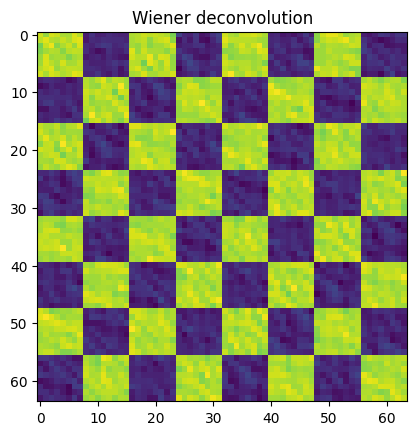

In [4]:
###############################################################################
""" Wiener deconvolution on noisy image
"""
SpecPuissNoise = np.abs(np.fft.fft2(noise))**2
PuissMoyNoise = np.mean(SpecPuissNoise)
SpecPuissImageOrig = np.abs(np.fft.fft2(C))**2
PuissMoyImageOrig = np.mean(SpecPuissImageOrig)
ratio = PuissMoyNoise/PuissMoyImageOrig

Hw = np.conjugate(H)/(np.abs(H)**2+ratio)
fr = np.fft.ifft2(Hw * np.fft.fft2(Cbn))
# really small imaginary part
plt.imshow(np.real(fr))
plt.title('Wiener deconvolution')
plt.imsave("cbn_wiener.png", np.real(fr), cmap='gray')

plt.show()

In [ ]:
###############################################################################
""" Van Cittert iterative filter
"""


def vca(g, psf, n_iter, beta=.01):
    """
    Van Cittert iterative filter
    g: noisy image
    psf: point spread function
    n_iter: number of iterations
    beta: Jansson parameter
    """
    H = psf2otf(psf, g.shape)

    # init iterations
    fr = g.copy()
    bar = progressbar.ProgressBar()
    for iter in bar(range(n_iter)):
        estimation = np.real(np.fft.ifft2(H * np.fft.fft2(fr)))
        fr = fr + beta * (g - estimation)

    return fr


fr = vca(Cbn, psf, 100)
plt.imshow(fr)
plt.title('Van Cittert algorithm')
plt.imsave("cbn_vca.png", np.real(fr), cmap='gray')
plt.show()


In [ ]:

###############################################################################
""" Richardson-Lucy iterative filter
"""


def rla(g, psf, n_iter):
    """
    Richardson Lucy algorithm
    g: noisy image
    psf: point spread function
    n_iter: number of iterations
    """
    H = psf2otf(psf, g.shape)
    # init iterations
    fr = g.copy()

    bar = progressbar.ProgressBar()
    for iter in bar(range(n_iter)):
        estimation = np.fft.ifft2(H * np.fft.fft2(fr))
        M = np.real(np.fft.ifft2(np.conjugate(
            H) * np.fft.fft2(g / estimation)))
        fr = fr * M
        fr[fr < 0] = 0

    return fr


fr = rla(Cbn, psf, 1000)
plt.imshow(fr)
plt.title('Richardson-Lucy algorithm')
plt.imsave("cbn_rla.png", np.real(fr), cmap='gray')
plt.show()

###############################################################################
""" Landweber iterative filter
"""


def lva(g, psf, n_iter, alpha=.5):
    """
    Landweber algorithm
    g: noisy image
    psf: point spread function
    n_iter: number of iterations
    """
    H = psf2otf(psf, g.shape)
    G = np.fft.fft2(g)

    fr = g.copy()
    FR = np.fft.fft2(g)
    bar = progressbar.ProgressBar()
    for iter in bar(range(n_iter)):
        estimation = H * FR
        FR = FR + alpha * np.conjugate(H) * (G - estimation)

    fr = np.real(np.fft.ifft2(FR))
    return fr


fr = lva(Cbn, psf, 1000, alpha=1)
plt.imshow(fr)
plt.title('Landweber algorithm')
plt.imsave("cbn_lva.png", np.real(fr), cmap='gray')
plt.show()

###############################################################################
""" Poisson Maximum A Posteriori filter
"""


def pmap(g, psf, n_iter):
    """
    Poisson Maximum A Posteriori algorithm
    g: noisy image
    psf: point spread function
    n_iter: number of iterations
    """
    H = psf2otf(psf, g.shape)

    fr = g.copy()
    bar = progressbar.ProgressBar()
    for iter in bar(range(n_iter)):
        estimation = np.real(np.fft.ifft2(H * np.fft.fft2(fr)))
        estimation[estimation <= 0] = np.inf
        M = np.real(np.fft.ifft2(np.conjugate(
            H) * np.fft.fft2(g / estimation)))
        fr = fr * np.exp(M-1)

    return fr


fr = pmap(Cbn, psf, 1000)
plt.imshow(fr)
plt.title('PMAP reconstruction')
plt.imsave("cbn_pmap.png", np.real(fr), cmap='gray')
plt.show()

################################################################################
# fits images
# load image
jupiter = False
if jupiter:
    hdu_list = fits.open('ic3g01qlq_drz.fits')
    hdu_list.info()
    image = hdu_list[1].data
    plt.imsave("jupiter.png", image, cmap='gray')
else:
    hdu_list = fits.open('saturn.fits')
    hdu_list.info()
    image = hdu_list[0].data
    plt.imsave("saturn.png", image, cmap='gray')

image = np.nan_to_num(image)
image = image / np.max(image)
image[image < 0] = 0
plt.imshow(image, cmap='gray')
plt.show()

# load PSF
if jupiter:
    # warning: if you print hdu_list.info(), you get this error:
    # AttributeError: '_ValidHDU' object has no attribute '_summary'
    hdu_list = fits.open('PSFSTD_WFC3UV_F275W.fits', ignore_missing_end=True)
    image_data = hdu_list[0].data
    imagepsf = image_data[1, :, :]
    plt.imsave("jupiter_psf.png", imagepsf)
else:
    hdu_list = fits.open('saturn_psf.fits', ignore_missing_end=True)
    image_data = hdu_list[0].data
    imagepsf = image_data
    plt.imsave("saturn_psf.png", imagepsf)
imagepsf = imagepsf / np.sum(imagepsf)
plt.imshow(imagepsf)
plt.show()


H = psf2otf(imagepsf, image.shape)
alpha = .01
G = np.fft.fft2(image)
H[H == 0] = np.Inf
F = G / (H+alpha)

fr = np.real(np.fft.ifft2(F))
plt.imshow(fr)
plt.title('Direct reconstruction')
if jupiter:
    plt.imsave("jupiter_direct.png", fr, cmap='gray')
else:
    plt.imsave("saturn_direct.png", fr, cmap='gray')

plt.show()

fr = vca(image, imagepsf, 10)
plt.imshow(fr)
plt.title('Van-Cittert reconstruction')
if jupiter:
    plt.imsave("jupiter_vca.png", fr, cmap='gray')
else:
    plt.imsave("saturn_vca.png", fr, cmap='gray')
plt.show()

fr = rla(image, imagepsf, 10)
plt.imshow(fr)
plt.title('Richardson-Lucy reconstruction')
if jupiter:
    plt.imsave("jupiter_rla.png", fr, cmap='gray')
else:
    plt.imsave("saturn_rla.png", fr, cmap='gray')
plt.show()

fr = lva(image, imagepsf, 200, alpha=1)
plt.imshow(fr)
plt.title('Landweber reconstruction')
if jupiter:
    plt.imsave("jupiter_lva.png", fr, cmap='gray')
else:
    plt.imsave("saturn_lva.png", fr, cmap='gray')
plt.show()


fr = pmap(image, imagepsf, 20)
plt.imshow(fr)
plt.title('PMAP reconstruction')
if jupiter:
    plt.imsave("jupiter_pmap.png", fr, cmap='gray')
else:
    plt.imsave("saturn_pmap.png", fr, cmap='gray')
plt.show()